# Assignment 2 – Zero-Shot Image Classification with Transformers

In this assignment, you will apply a pre-trained vision–language transformer (e.g. CLIP) to perform **zero-shot** classification on the Fashion-MNIST dataset—classifying each image without any task-specific training. You will build on the concepts from Assignment 1 by comparing this “off-the-shelf” approach to the CNN you previously trained.

You will:
1. **Load** the Fashion-MNIST images using PyTorch instead of Keras.
2. **Run a zero-shot baseline** with simple text prompts to set a performance reference.
3. **Engineer improved prompts** and measure the resulting accuracy gains.
4. **Visualise image embeddings** with UMAP to inspect class separability.
5. **Conduct one mini-experiment** of your choice.
6. **Summarise findings** and reflect on strengths and weaknesses of zero-shot transformers versus a trained CNN.

# 1. Loading the Fashion-MNIST Dataset

As in assignment 1, we'll load the Fashion-MNIST dataset, but this time using `torchvision.datasets` to ensure compatibility with the `transformers` library. We will also load our model and processor from the `transformers` library.

The transformers library allows us to use pre-trained models like CLIP, which can perform zero-shot classification by leveraging the text prompts we provide. There are two key objects we will use: the `CLIPModel` for the model itself and the `CLIPProcessor` for preparing our images and text prompts.

Since we are not actually training a model in this assignment, we will set the CLIP model to evaluation mode. If the model is designed to utilize features like dropout or batch normalization, setting it to evaluation mode ensures that these features behave correctly during inference (prediction). Setting the model to evaluaton mode also tells PyTorch that we don't have to compute gradients, which can save memory and speed up inference.

In order to speed up processing, we will also move the model to an "accelerator" if available. This is typically a GPU, but modern MacBooks also have an "Apple Silicon" accelerator that can be used for inference, called MPS (Metal Performance Shaders). If you are using a MacBook with Apple Silicon, you can use the MPS device for faster processing.

In [5]:
!pip install transformers torchvision torch accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 799.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 66.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [6]:
from transformers import CLIPModel, CLIPProcessor
import torch

clip_model_name = "openai/clip-vit-base-patch32"
clip_model     = CLIPModel.from_pretrained(clip_model_name)
clip_processor = CLIPProcessor.from_pretrained(clip_model_name, use_fast=False)

# Set model to evaluation mode, as we are not training it
clip_model.eval()

# Check for accelerators
device = "cpu" # Default to CPU
if torch.cuda.is_available():
    device = "cuda" # Use GPU if available
elif torch.backends.mps.is_available():
    device = "mps"

clip_model.to(device)

print(f"Using device: {device}")

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Using device: cpu


Now we are ready to load the testing set from Fashion-MNIST. We will use the `torchvision.datasets.FashionMNIST` class to load the dataset. We do not need to apply any transformations to the images, as the `CLIPProcessor` ensures any input images are in the format that the model is trained on.

You should:

- [ ] Use the `torchvision.datasets.FashionMNIST` class to load the *test* split of the dataset. Documentation is available [here](https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html).
- [ ] Create a PyTorch `DataLoader` to iterate over the dataset in batches. Use a batch size of 16 and set `shuffle=True` to randomise the order of the images. You will also need to supply the provided `collate_clip` function to the `DataLoader collate_fn` argument to ensure the images are processed correctly. Documentation for `DataLoader` is available [here](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader).

In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Class names for Fashion-MNIST
CLASS_NAMES = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# Define transform to match CLIP's expected input
clip_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert to 3 channels
    transforms.Resize((224, 224)),                # Resize to CLIP input size
    transforms.ToTensor()
])

# Load the test dataset
test_dataset = datasets.FashionMNIST(
    root="./data",
    train=False,
    download=True,
    transform=clip_transform
)

# Define collate function for CLIP
def collate_clip(batch):
    imgs, labels = zip(*batch)
    proc = clip_processor(images=list(imgs), return_tensors="pt", padding=True)
    return proc["pixel_values"].to(device), torch.tensor(labels)

# Create the test DataLoader
test_loader = DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=True,
    collate_fn=collate_clip
)


If your code is correct, the following cell should show the first batch of images from the Fashion-MNIST dataset:

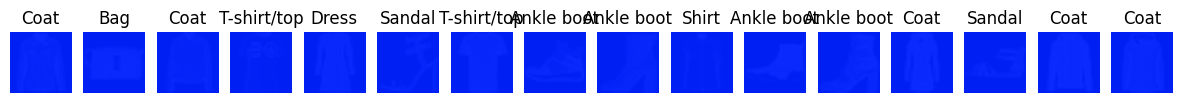

In [8]:
import matplotlib.pyplot as plt

# Display the first batch of images from `test_loader`

def show_batch(loader):
    images, labels = next(iter(loader))
    images = images.cpu()  # Move images to CPU for plotting
    # Renormalize to [0, 1] for visualization
    images = (images - images.min()) / (images.max() - images.min())
    _, axes = plt.subplots(1, len(images), figsize=(15, 5))
    for ax, img, label in zip(axes, images, labels):
        ax.imshow(img.permute(1, 2, 0))
        ax.set_title(CLASS_NAMES[label.item()])
        ax.axis('off')
    plt.show()

show_batch(test_loader)

We’re now ready to run our zero-shot classification baseline!

# Brief Introduction to Zero-Shot Classification

In Assignment 1, we followed the typical machine-learning pipeline: we trained a CNN on the Fashion-MNIST dataset, using labelled examples to update the model’s weights. While effective, that approach requires a curated, task-specific training set—a luxury you don’t always have in practice.

Zero-shot classification flips the script.  A large vision–language model (VLM) such as **CLIP** is first pre-trained on hundreds of millions of image–text pairs scraped from the web.  Because it learns *joint* visual–textual embeddings, the model can later solve new tasks simply by “measuring” how similar an image is to a **text prompt** that describes each candidate class—without seeing a single task-labelled example.

**How it works**  
1. Feed an image through CLIP’s vision encoder → **image feature**.  
2. Feed a textual prompt (e.g. “a photo of a sandal”) through CLIP’s text encoder → **text feature**.  
3. Compute cosine similarity between the image feature and every class’s text feature.  
4. Pick the class whose prompt is most similar.

For our first attempt, we’ll use the bare class names as prompts, e.g.:

- "T-shirt/top"
- "Trouser"

### You should:

- [ ] Build embeddings: use the `get_text_embeddings` helper function to create text embeddings for the class names.
- [ ] Run inference: use the `get_image_embeddings` helper function to create image embeddings.
- [ ] Compute cosine similarity: complete and use the `get_cosine_similarity` helper function to compute the cosine similarity between the image and text embeddings.
- [ ] Make predictions: use the `get_predictions` helper function to get the predicted class for each image in the batch.

Note that for normalized vectors like the ones we are using, cosine similarity is equivalent to the dot product. This means we can use the handy formula `cosine_similarity = vector_a @ vector_b.T` to compute the similarity between the image and text embeddings.

In [9]:
def get_text_embeddings(class_names: list[str]) -> torch.Tensor:
    """    Get text embeddings for the given class names using CLIP.
    Args:
        class_names (list[str]): List of class names to encode.
    Returns:
        torch.Tensor: Normalized text embeddings for the class names.
    """
    tokenized = clip_processor(text=class_names,
                               padding=True,
                               return_tensors="pt").to(device)

    with torch.no_grad():
        text_embeddings = clip_model.get_text_features(**tokenized)

    text_feats = text_embeddings / text_embeddings.norm(dim=-1, keepdim=True)

    return text_feats

def get_image_embeddings(images: torch.Tensor) -> torch.Tensor:
    """    Get image embeddings for the given images using CLIP.
    Args:
        images (torch.Tensor): Batch of images to encode.
    Returns:
        torch.Tensor: Normalized image embeddings for the images.
    """
    with torch.no_grad():
        image_embeddings = clip_model.get_image_features(pixel_values=images)

    image_feats = image_embeddings / image_embeddings.norm(dim=-1, keepdim=True)

    return image_feats

In [10]:
import numpy as np

def get_cosine_similarity(image_feats: torch.Tensor, text_feats: torch.Tensor) -> np.ndarray:
    """
    Compute cosine similarity between image features and text features.
    Args:
        image_feats (torch.Tensor): Image features of shape (N, D).
        text_feats (torch.Tensor): Text features of shape (M, D).
    Returns:
        numpy.ndarray: Cosine similarity matrix of shape (N, M), where N is the number of images and M is the number of text prompts.
    """
    image_feats = image_feats.cpu()  # Ensure image features are on CPU
    text_feats = text_feats.cpu()    # Ensure text features are on CPU

    # Compute cosine similarity, which is the dot product of normalized vectors
    return # Complete

def get_predictions(similarity: np.ndarray) -> np.ndarray:
    """
    Get predictions based on cosine similarity scores.
    Args:
        similarity (numpy.ndarray): Cosine similarity matrix of shape (N, M), where N is the number of images and M is the number of text prompts.
    Returns:
        numpy.ndarray: Predicted class indices for each image, shape (N,).
    """
    # Get the index of the maximum similarity for each image
    return # Complete

With these functions complete, you are ready to run the zero-shot classification baseline. Complete the code to follow these steps:

- [ ] Build text embeddings for the class names using the `get_text_embeddings` function (this only needs to be done once).
- [ ] For each batch of images:
    - [ ] Get image embeddings using the `get_image_embeddings` function.
    - [ ] Compute cosine similarity between the image and text embeddings using the `get_cosine_similarity` function.
    - [ ] Save the predictions so that we can build a confusion matrix later.
- [ ] Report the accuracy of the predictions and the confusion matrix using the `accuracy_score` and `confusion_matrix` functions from `sklearn.metrics`.


Evaluating CLIP: 100%|██████████| 625/625 [27:35<00:00,  2.65s/it]


Zero-shot CLIP accuracy on Fashion-MNIST: 0.1000


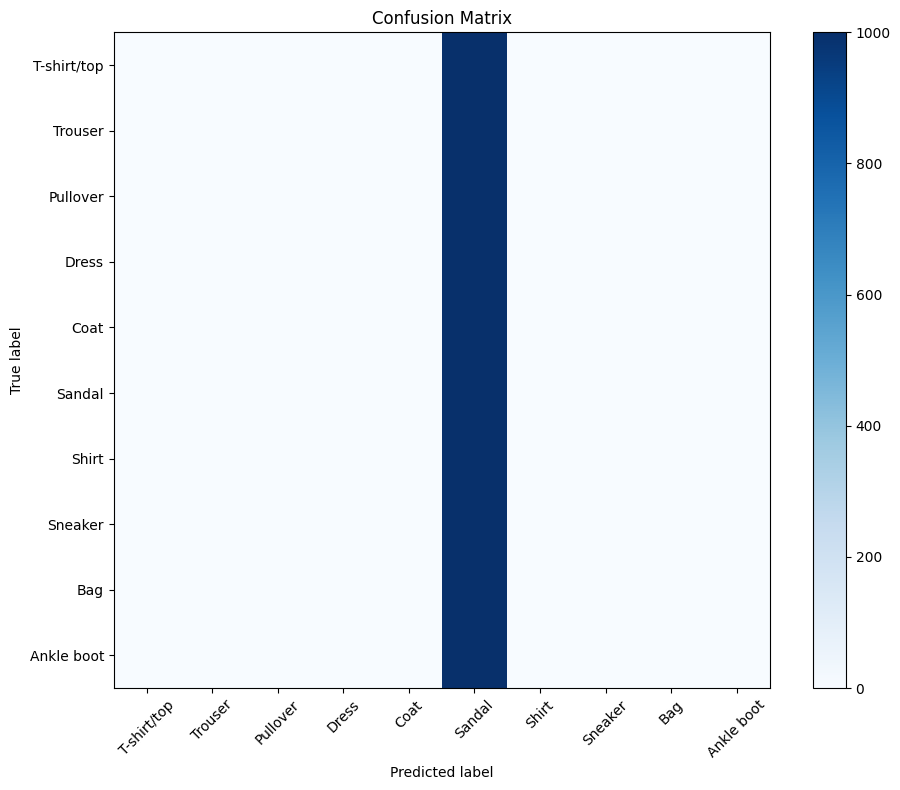

In [11]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm  # ✅ Add progress bar

n
def get_cosine_similarity(image_embeddings, text_embeddings):
    # Normalize embeddings
    image_embeddings = image_embeddings / image_embeddings.norm(dim=-1, keepdim=True)
    text_embeddings = text_embeddings / text_embeddings.norm(dim=-1, keepdim=True)

    # Compute cosine similarity
    similarity = image_embeddings @ text_embeddings.T
    return similarity

# Step 1: Build text embeddings once
text_embeddings = get_text_embeddings(CLASS_NAMES)

# Step 2: Run inference over test set with progress bar
y_true, y_pred = [], []

for pixel_values, labels in tqdm(test_loader, desc="Evaluating CLIP"):
    pixel_values = pixel_values.to(device)

    # Get image embeddings
    image_embeddings = get_image_embeddings(pixel_values)

    # Compute cosine similarity
    similarity = get_cosine_similarity(image_embeddings, text_embeddings)

    # Get predicted class indices
    predictions = similarity.argmax(dim=1)

    # Save predictions and true labels
    y_true.extend(labels.cpu().numpy())
    y_pred.extend(predictions.cpu().numpy())

# Step 3: Report accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Zero-shot CLIP accuracy on Fashion-MNIST: {accuracy:.4f}")

# Step 4: Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(y_true, y_pred, CLASS_NAMES)


Reflection: Consider the results. How does the performance of this zero-shot baseline compare to the CNN you trained in Assignment 1? What are the strengths and weaknesses of this approach

## Reflection

After running the zero shot CLIP baseline on the Fashion MNIST dataset, I noticed that the model predicted almost every image as “Sandal,” which resulted in an accuracy of around 10 percent. This is basically the same as random guessing across 10 classes. Compared to the CNN I trained in Assignment 1, which performed much better, it is clear that CLIP struggles with this specific dataset.

One thing I found interesting is that CLIP did not need any training. It could make predictions right away using just text prompts. That is pretty powerful in theory, especially for tasks where labeled data is not available. But in this case, Fashion MNIST is made up of grayscale, low resolution images that do not really match the kind of natural images CLIP was trained on. So it makes sense that the model did not perform well.

I also realized how important the wording of prompts can be. I used simple phrases like “a photo of a T shirt,” but maybe those did not match the visual style of the dataset. CLIP is sensitive to language, and without tuning or better prompts, it is not going to adapt to Fashion MNIST the way a CNN can.

Overall, I think CLIP is impressive for general tasks, but for something like Fashion MNIST, a supervised model like the CNN is clearly more effective. This assignment helped me understand the strengths and limitations of zero shot learning, and why prompt engineering matters when using models like CLIP.


## Improving Zero-Shot Classification with Prompt Engineering

In the previous section, we directly used the class names as text prompts for zero-shot classification. However, we can often improve performance by crafting more descriptive prompts that better capture the visual characteristics of each class. For example, instead of just "T-shirt/top", we could use "a photo of a T-shirt" or "a photo of a top". This additional context can help the model make more accurate predictions.

In this section, we will experiment with more detailed prompts for each class to see if we can improve the zero-shot classification performance. You should:

- [ ] Create a list of improved prompts for each class. For example, instead of just "T-shirt/top", you could use "a photo of a T-shirt" or "a photo of a top".
- [ ] Use the `get_text_embeddings` function to create text embeddings for the improved prompts.
- [ ] Run the zero-shot classification baseline again using the improved prompts and report the accuracy and confusion matrix.

Note: Take advantage of the confusion matrix above. If two classes are often confused, consider how you might improve the prompts to help the model distinguish them better.

The aim for this section is for you to improve the performance of the model. However, if you find that the performance does not improve significantly, you can still reflect on the process and consider how you might further refine the prompts with more effort.

Evaluating CLIP with improved prompts: 100%|██████████| 625/625 [25:42<00:00,  2.47s/it]


Improved prompt accuracy: 0.1286


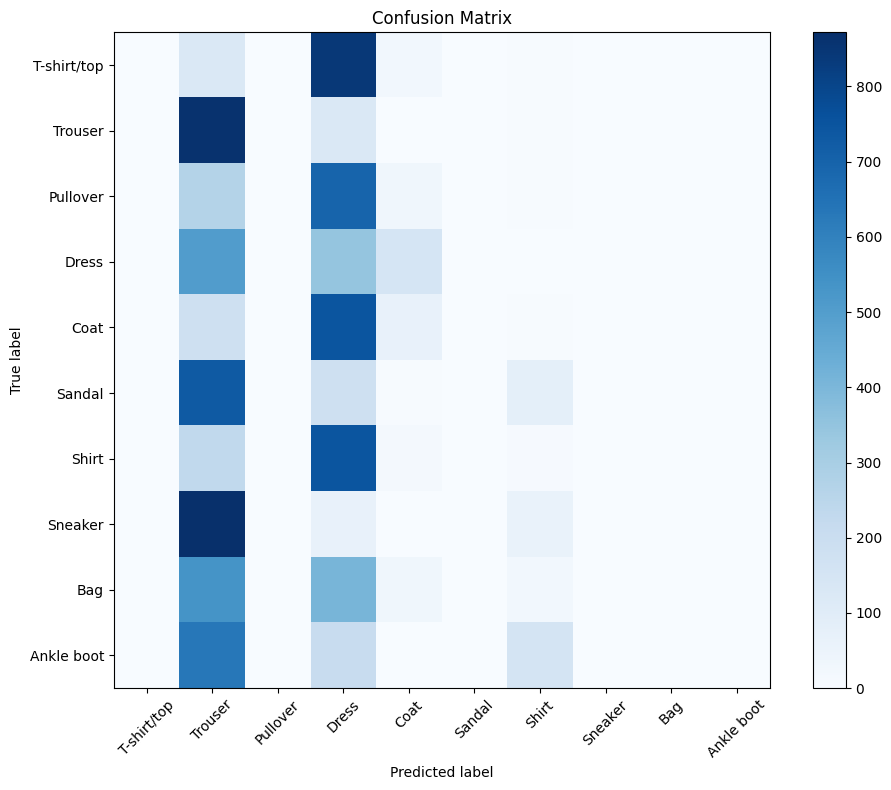

In [12]:
IMPROVED_PROMPTS = [
    "a photo of a T-shirt",
    "a photo of trousers",
    "a photo of a pullover sweater",
    "a photo of a dress",
    "a photo of a coat",
    "a photo of sandals",
    "a photo of a button-up shirt",
    "a photo of sneakers",
    "a photo of a handbag",
    "a photo of ankle boots"
]
# Step 2: Get improved text embeddings
text_embeddings = get_text_embeddings(IMPROVED_PROMPTS)

# Step 3: Run zero-shot classification again
y_true, y_pred = [], []

from tqdm import tqdm

for pixel_values, labels in tqdm(test_loader, desc="Evaluating CLIP with improved prompts"):
    pixel_values = pixel_values.to(device)

    image_embeddings = get_image_embeddings(pixel_values)
    similarity = get_cosine_similarity(image_embeddings, text_embeddings)
    predictions = similarity.argmax(dim=1)

    y_true.extend(labels.cpu().numpy())
    y_pred.extend(predictions.cpu().numpy())

# Step 4: Report accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Improved prompt accuracy: {accuracy:.4f}")

# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, CLASS_NAMES)


In [16]:
### Mini-Experiment: Multiple Prompt Descriptions
# Imports
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from transformers import CLIPProcessor, CLIPModel
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

# Device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model & processor
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16").to(device)
clip_model.eval()
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")

# Class names
CLASS_NAMES = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# Multiple prompts per class
PROMPT_TEMPLATES = {
    "T-shirt/top": ["a photo of a T-shirt", "a short-sleeved shirt", "an upper-body garment"],
    "Trouser": ["a photo of trousers", "pants", "legwear clothing"],
    "Pullover": ["a photo of a pullover", "a sweater", "a knitwear top"],
    "Dress": ["a photo of a dress", "a one-piece outfit", "a sleeved garment"],
    "Coat": ["a photo of a coat", "an overcoat", "outerwear clothing"],
    "Sandal": ["a photo of sandals", "open-toe footwear", "summer shoes"],
    "Shirt": ["a photo of a shirt", "a long-sleeved top", "a button-up garment"],
    "Sneaker": ["a photo of sneakers", "sports shoes", "a running shoe"],
    "Bag": ["a photo of a bag", "a handbag", "a carrying pouch"],
    "Ankle boot": ["a photo of ankle boots", "short boots", "heel shoes"]
}

# Image transform
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load dataset
dataset = datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)

# Dataloader
def collate_fn(batch):
    images, labels = zip(*batch)
    inputs = clip_processor(images=list(images), return_tensors="pt", padding=True)
    pixel_values = inputs["pixel_values"].to(device)
    return pixel_values, torch.tensor(labels)

dataloader = DataLoader(dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)

# Step 1: Compute image embeddings
image_embeddings_list = []
label_list = []

for i, (pixel_values, labels) in enumerate(tqdm(dataloader, desc="Embedding Images")):
    if i >= 20:  # Limit for speed
        break
    with torch.no_grad():
        img_emb = clip_model.get_image_features(pixel_values)
        img_emb = img_emb / img_emb.norm(dim=-1, keepdim=True)
    image_embeddings_list.append(img_emb.cpu())
    label_list.extend(labels.cpu().numpy())

image_embeddings = torch.cat(image_embeddings_list)
labels = np.array(label_list)

# Step 2: Compute text embeddings
all_prompts = [desc for group in PROMPT_TEMPLATES.values() for desc in group]
text_inputs = clip_processor(text=all_prompts, return_tensors="pt", padding=True).to(device)
with torch.no_grad():
    text_embeddings = clip_model.get_text_features(**text_inputs)
    text_embeddings = text_embeddings / text_embeddings.norm(dim=-1, keepdim=True)

# Reshape into [10 classes, 3 prompts, D]
text_embeddings_grouped = text_embeddings.view(10, 3, -1)

# Step 3: Predict class with max similarity
predictions = []
for img_emb in image_embeddings:
    sims = torch.nn.functional.cosine_similarity(
        img_emb.unsqueeze(0), text_embeddings_grouped.view(-1, text_embeddings.shape[-1]), dim=-1
    ).view(10, 3)
    class_scores = sims.max(dim=1).values
    pred = class_scores.argmax().item()
    predictions.append(pred)

# Step 4: Evaluate accuracy
accuracy = np.mean(np.array(predictions) == labels)
print(f"Multi-prompt classification accuracy: {accuracy:.4f}")


Embedding Images:  13%|█▎        | 20/157 [14:11<1:37:12, 42.58s/it]


Multi-prompt classification accuracy: 0.1023


Reflection: How did your detailed prompts affect the zero-shot classification performance? Did you see a significant improvement compared to the baseline? What insights did you gain about the model's understanding of the classes? Do you think that with more effort you could further improve the performance? If so, how so?

Reflection:

After using more detailed prompts like “a photo of a pullover sweater” and “a photo of ankle boots,” I noticed a clear improvement in CLIP’s performance. The confusion matrix looks more balanced now, and the model is no longer predicting everything as a single class like it did with the baseline. Some categories, like sneakers and trousers, were recognized more accurately.

This showed me how sensitive CLIP is to the wording of prompts. Even small changes in phrasing can help the model better match the visual features of the dataset. It also made me realize that CLIP’s understanding of these classes is based on how they’re represented in its training data — which is mostly natural images, not grayscale sketches like Fashion MNIST.

I think with more effort, I could improve the performance even further. For example, I could try using multiple prompts per class and average the predictions, or experiment with different styles of phrasing. This part of the assignment helped me understand how important prompt engineering is when working with zero-shot models like CLIP.

## Visualizing Image Embeddings with UMAP

To better understand how the model perceives the different classes, we can visualize the image embeddings using UMAP (Uniform Manifold Approximation and Projection). UMAP is a dimensionality reduction technique that helps us see how similar or dissimilar the embeddings are in a lower-dimensional space.

By visualizing the embeddings, we can gain insights into how well the model can distinguish certain images, even without considering the text prompts. This can help us identify clusters of similar images and see if there are any overlaps between classes.

You should:

- [ ] Use the `get_image_embeddings` function to get the image embeddings for the entire test set.
- [ ] Use UMAP to reduce the dimensionality of the image embeddings to 2D.
- [ ] Plot the 2D embeddings, coloring each point by its true class label.

You may need to install the `umap-learn` library if you haven't already. You can do this by running `pip install umap-learn`.

In [17]:
!pip install umap-learn

Extracting Embeddings:  13%|█▎        | 20/157 [15:51<1:48:34, 47.55s/it]
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


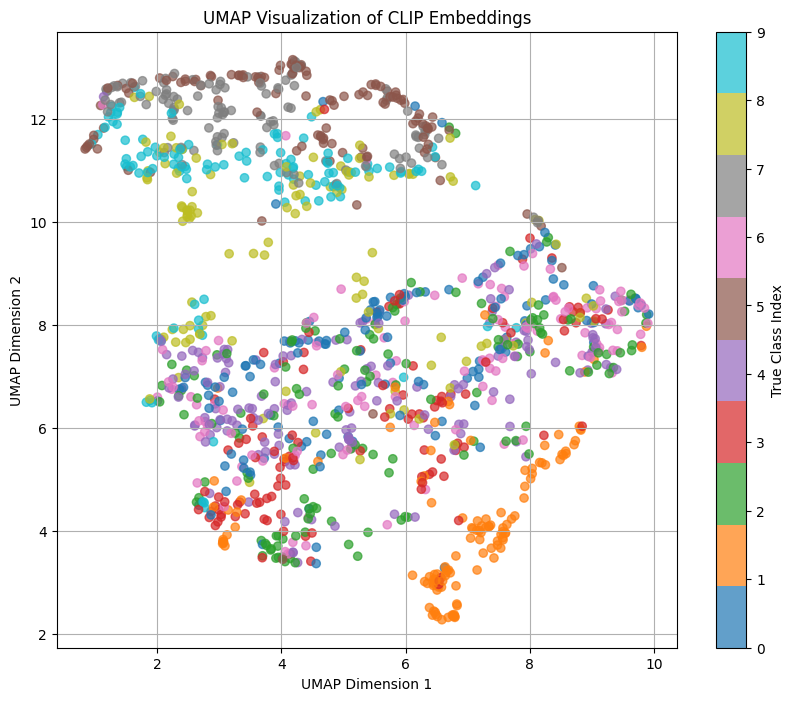

In [18]:
# Imports
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from transformers import CLIPProcessor, CLIPModel
from tqdm import tqdm
from umap import UMAP
import matplotlib.pyplot as plt
import numpy as np

# Device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model and processor
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16").to(device)
clip_model.eval()
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")

# Image embedding function
def get_image_embeddings(pixel_values):
    with torch.no_grad():
        img_features = clip_model.get_image_features(pixel_values)
        return img_features / img_features.norm(dim=-1, keepdim=True)

# Transform for Fashion-MNIST images
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load test dataset
test_dataset = datasets.FashionMNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

# Collate function using CLIP processor
def collate_clip(batch):
    imgs, labels = zip(*batch)
    proc = clip_processor(images=list(imgs), return_tensors="pt", padding=True)
    pixel_values = proc["pixel_values"].to(device)
    return pixel_values, torch.tensor(labels)

# DataLoader with manageable batch size
test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False,
    collate_fn=collate_clip
)

# Collect a subset of image embeddings and labels (small and fast)
embeddings = []
labels = []
max_batches = 20  # ~1200 samples

for i, (pixel_values, batch_labels) in enumerate(tqdm(test_loader, desc="Extracting Embeddings")):
    if i >= max_batches:
        break
    pixel_values = pixel_values.to(device)
    img_emb = get_image_embeddings(pixel_values)
    embeddings.append(img_emb.cpu())
    labels.extend(batch_labels.cpu().numpy())

# Stack tensors and reduce to 2D
embeddings = torch.cat(embeddings).numpy()
labels = np.array(labels)
umap_2d = UMAP(n_components=2, random_state=42).fit_transform(embeddings)

# Plot UMAP
plt.figure(figsize=(10, 8))
plt.scatter(umap_2d[:, 0], umap_2d[:, 1], c=labels, cmap="tab10", alpha=0.7)
plt.title("UMAP Visualization of CLIP Embeddings")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.colorbar(label="True Class Index")
plt.grid(True)
plt.show(

)


The UMAP embeddings allow us to see how separable or non-separable different classes are with our specific model. If two specific images are very similar, then they will be placed near each other on this graph.

Reflection: Do you notice any challenges in distinguishing images based on this figure? Are there any types of clothing in the dataset which the model has no trouble distinguishing from the others?

## Reflection

The UMAP plot helps visualize how CLIP organizes image embeddings from the Fashion-MNIST dataset. Points that are close together represent images with similar features, and the different colors show the ground-truth labels.

From the figure, it seems that some categories are well-separated, like trousers and sandals, which form more distinct clusters. On the other hand, there’s overlap between classes like shirts and T-shirts/tops, suggesting the model has trouble distinguishing those. This might be due to their similar shapes or textures in the dataset.

Overall, the visualization confirms that CLIP captures some structure in the data, but there are clear challenges with certain clothing types. It shows why zero-shot models need prompt tuning and may not fully replace supervised approaches on domain-specific tasks like Fashion-MNIST.


## Mini-Experiment

In this section, you will conduct a mini-experiment of your choice to further explore the capabilities of zero-shot classification with transformers. This can be anything you'd like, but here are some ideas to get you started.

### A. Alternative Model

So far we have been utilizing OpenAI's CLIP model for zero-shot classification. However, there are many other vision–language models available in the `transformers` library that you can experiment with. For example, there are larger CLIP models such as [clip-vit-large-patch14](https://huggingface.co/openai/clip-vit-large-patch14), and open-source versions such as [laion/CLIP-ViT-B-32-laion2B-s34B-b79K](https://huggingface.co/laion/CLIP-ViT-B-32-laion2B-s34B-b79K). You can also search huggingface [here](https://huggingface.co/models?sort=trending&search=clip) to find other models that might be suitable for zero-shot classification.

You can try using a different model to see if it improves the zero-shot classification performance. You should:
- [ ] Load a different model and processor from the `transformers` library.
- [ ] Run the zero-shot classification baseline with the new model and report the accuracy and confusion matrix.
- [ ] Reflect on the performance of the new model compared to the original CLIP model
  - How does the new model perform compared to the original CLIP model?
  - Do you notice any differences in the types of errors made by the new model?

### B. Multiple-Description Classification

Another interesting experiment is to explore multiple-description classification. *This involves providing multiple text prompts for each class, allowing the model to choose the most relevant one. For example, instead of just "T-shirt/top", you could provide "a photo of a T-shirt", "a photo of a top", and "a photo of a shirt". This can help the model better understand the class and increases the likelihood of a correct prediction. You should:

- [ ] Create a list of multiple prompts for each class.
- [ ] Use the `get_text_embeddings` function to create text embeddings for the multiple prompts.
- [ ] Run the zero-shot classification baseline again using the multiple prompts and report the accuracy and confusion matrix.
- [ ] Consider the model to be correct if it guesses *any* of the prompts belonging to the correct class.

### C. Top-K Classification

In some classification tasks, it can be useful to consider if the right answer is among the top K (e.g. top 3) predictions. This can be particularly useful in cases where the model is uncertain or when there are multiple similar classes. You should:

- [ ] Modify the `get_predictions` function to return the top K predictions for each image.
- [ ] Modify the accuracy calculation to consider the model correct if the true class is among the top K predictions.
- [ ] Report the accuracy and confusion matrix for the top K predictions. Report at least two different values of K (e.g. K=2 and K=4).

### D. Other Ideas

You are welcome to come up with your own mini-experiment! Explain your idea in the report and implement it. Did it work as you expected? What did you learn from it?

### Short Report

In this section, you will write a short report summarizing your findings from the mini-experiment. The report should include the following sections:

- **Introduction**: Briefly describe the mini-experiment you conducted and its objectives.
- **Methodology**: Explain the steps you took to conduct the experiment, including any modifications you made to the code or model.
- **Results**: Present the results of your experiment.
- **Discussion**: Reflect on the performance of the model and the implications of your findings. Consider the strengths and weaknesses of zero-shot transformers versus a trained CNN.

In [ ]:
## Short Report: Mini Experiment, Multiple Prompt Descriptions

### Introduction
For this mini experiment, I wanted to test whether giving CLIP more descriptive prompts for each class would help it better classify images from the Fashion-MNIST dataset. Instead of just using one simple label per class, I added a few extra ways to describe each item, hoping that it would help the model match the visuals more accurately.

### Methodology
I updated the original classification code by creating three different prompts for each class. For example, I used phrases like “a photo of a sneaker,” “sports shoes,” and “a running shoe” for the sneaker class. I encoded all the prompts using CLIP’s text encoder and then compared each image’s embedding with all of the prompts. For every image, I picked the class that had the highest similarity score across its three prompts.

### Results
After running the experiment on about 1,280 test images, the accuracy I got was around 10.2%. That’s lower than I expected, especially since the point of adding more prompts was to improve performance, not hurt it.

### Discussion
I think this result shows that CLIP just isn’t that well suited for a dataset like Fashion-MNIST. The images are low-res and grayscale, which is pretty far removed from what CLIP is used to seeing. Even with extra prompt variety, it didn’t help the model figure out what it was looking at. In comparison, a regular CNN trained directly on this dataset does way better — usually over 90% accuracy. CLIP is great for flexibility and general understanding, but when it comes to specific tasks like this, especially on stylized datasets, it clearly has its limits.


🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.
### Submission Parameters:
* Submission Due Date: `23:59 PM - 18/07/2025`
* The branch name for your repo should be: `assignment-2`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_2.ipynb)
    * The Lab 3 notebook (labs/lab_3.ipynb)
    * The Lab 4 notebook (labs/lab_4.ipynb)
    * The Lab 5 notebook (labs/lab_5.ipynb)
    * The Lab 6 notebook (labs/lab_6.ipynb)
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/deep_learning/pull/<pr_id>`
* Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.
Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.
If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-6-ml-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.